# COMP90014 Assignment 2
### Semester 2, 2019

**Task 6 has been ammended - please use this version

This assignment should be completed by each student individually. Make sure you read this entire document, and ask for help if anything is not clear. Any changes or clarification to this document will be announced via the LMS.

Please make sure you are aware of the University's rules on academic honesty and plagiarism, which are very strict: https://academichonesty.unimelb.edu.au/ 

Make sure you **do not** copy any code either from other students or from the internet. This is considered plagiarism. It is generally a good idea to avoid looking at any solutions as you may find it surprisingly difficult to generate your own solution to the problem once you have seen somebody else's.

Your completed notebook file containing all your answers will be turned in via LMS. No other files or formats will be accepted - only upload the completed `.ipynb` file.

### Overview
To complete the assignment you will need to finish the tasks in this notebook. There are multiple tasks that are connected in a logical order.

The tasks are a combination of writing your own implementations of algorithms we've discussed in lectures, writing your own code to use library implementations of these algorithms and interpreting the results in short answer format. Each short answer question has a word limit that will be strictly enforced! **Please note that for this assignment, you may be awarded a mark of zero for a question if you go over the word limit.**

In some case, we have provided test input and test output that you can use to try out your solutions. These tests are just samples and are not exhaustive - they may warn you if you've made a mistake, but they are not guaranteed to. It's up to you to decide whether your code is correct.

### Marking

Cells that must be completed to receive marks are clearly labeled. There are 19 graded cells, some of which are code cells, in which you must complete the code to solve a problem, and some of which are markdown cells, in which you must write your answers to short-answer questions. 

In this assignment, every graded cell is worth 2 marks. In addition to the graded cells, up to 7 marks will be given for code style, readability, efficiency and comments. 

The total marks for the assignment add up to 45, and it will be worth 15% of your overall subject grade.

Please make sure that you do not edit the "GRADED CELL" comments in either the code or the markdown cells, as this will disrupt the marking system.

### Background and data 

WGCNA stands for weighted gene co-expression network analysis. It is a data analysis technique used for studying biological networks based on pairwise correlations of gene expression data. WGCNA is good at identifying clusters of genes that may be co-regulated, and therefore may have shared biological function.

For this assignment, you will primarily be using the [FlyAtlas](http://flyatlas.org) dataset. For this assignment, instead of using the probe-wise dataset, we will be using the expression value for each gene.



## Task 0 - Setup 

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import altair

In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy
import re
from io import StringIO
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

### Read in data

In [8]:
raw_expression = pd.read_csv('flyatlas_subset.csv.gz', index_col=0)

In [9]:
raw_expression.head()

,Adult Hind Gut biological rep1,Adult Hind Gut biological rep2,Adult Hind Gut biological rep3,Adult Hind Gut biological rep4,Adult Mid Gut biological rep1,Adult Mid Gut biological rep2,Adult Mid Gut biological rep3,Adult Mid Gut biological rep4,Adult Accessory gland biological rep1,Adult Accessory gland biological rep2,...,Adult Thoracic Muscle biological rep3,Adult Thoracic Muscle biological rep4,Adult Wings biological rep1,Adult Wings biological rep2,Adult Wings biological rep3,Adult Wings biological rep4,Adult Female Spermatheca Mated (REDONE) biological rep1,Adult Female Spermatheca Mated (REDONE) biological rep2,Adult Female Spermatheca Mated (REDONE) biological rep3,"Adult Female Spermatheca Mated (REDONE) biological rep4"""
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
128up,214.51500,246.59700,216.58100,221.66700,264.602000,281.02000,300.132000,255.19500,427.68900,467.309000,...,113.9360,363.59600,196.98400,262.50700,181.05800,204.36200,380.878000,112.6860,294.49000,329.094000
140up,139.86300,181.65600,143.80200,149.44800,92.043300,82.10540,77.407200,91.44190,116.91800,124.892000,...,155.8030,110.83100,79.40570,81.80540,76.40320,68.40710,85.908800,128.3340,87.18940,104.890000
18w,241.72200,247.02900,245.75500,262.18900,54.108400,60.05170,60.698900,54.93600,33.02630,39.497000,...,100.4050,294.09100,772.38800,700.44800,752.14300,754.71500,285.764000,66.5310,248.04200,264.250000
312,4.16597,2.60007,3.53377,4.60587,0.194508,0.57742,0.977839,2.65123,8.84807,0.342770,...,68.3797,0.36183,7.03675,2.94253,8.25821,5.44387,5.008850,35.0969,2.39418,2.270310
7B2,25.78430,19.12000,34.80000,21.64910,89.001700,116.57100,114.170000,123.40500,2.34292,0.618435,...,175.8510,1.38861,172.11500,194.96700,128.78000,183.37900,0.842605,16.0162,2.64286,0.579274


The data frame has 18952 rows (measurements) and 136 columns (samples) so it is certainly high dimensional.These 136 columns represent 4 replicates each from 34 different tissue types.

We will set numpy and pandas to display numbers to just two decimal places in this notebook - this won't affect the actual numbers, just their display, and you can change it if you prefer.

In [10]:
np.set_printoptions(precision=2)
pd.options.display.precision=2

In [11]:
# The actual stored numbers have not changed
raw_expression.head()

,Adult Hind Gut biological rep1,Adult Hind Gut biological rep2,Adult Hind Gut biological rep3,Adult Hind Gut biological rep4,Adult Mid Gut biological rep1,Adult Mid Gut biological rep2,Adult Mid Gut biological rep3,Adult Mid Gut biological rep4,Adult Accessory gland biological rep1,Adult Accessory gland biological rep2,...,Adult Thoracic Muscle biological rep3,Adult Thoracic Muscle biological rep4,Adult Wings biological rep1,Adult Wings biological rep2,Adult Wings biological rep3,Adult Wings biological rep4,Adult Female Spermatheca Mated (REDONE) biological rep1,Adult Female Spermatheca Mated (REDONE) biological rep2,Adult Female Spermatheca Mated (REDONE) biological rep3,"Adult Female Spermatheca Mated (REDONE) biological rep4"""
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
128up,214.51,246.60,216.58,221.67,264.60,281.02,300.13,255.19,427.69,467.31,...,113.94,363.60,196.98,262.51,181.06,204.36,380.88,112.69,294.49,329.09
140up,139.86,181.66,143.80,149.45,92.04,82.11,77.41,91.44,116.92,124.89,...,155.80,110.83,79.41,81.81,76.40,68.41,85.91,128.33,87.19,104.89
18w,241.72,247.03,245.75,262.19,54.11,60.05,60.70,54.94,33.03,39.50,...,100.41,294.09,772.39,700.45,752.14,754.72,285.76,66.53,248.04,264.25
312,4.17,2.60,3.53,4.61,0.19,0.58,0.98,2.65,8.85,0.34,...,68.38,0.36,7.04,2.94,8.26,5.44,5.01,35.10,2.39,2.27
7B2,25.78,19.12,34.80,21.65,89.00,116.57,114.17,123.41,2.34,0.62,...,175.85,1.39,172.12,194.97,128.78,183.38,0.84,16.02,2.64,0.58


In [12]:
log_expression = np.log(raw_expression)

The following code snippet removes the replicate name from each sample, so we can use these labels as categories for plotting later.

In [13]:
tissues_list = [re.match('(.+?)(( biological)? rep\d+)', c).group(1)
                     for c in raw_expression.columns]
tissues = pd.Series(tissues_list, index = raw_expression.columns)

In [14]:
len(tissues)

136

## Task 1 - Building a correlation matrix

**Task 1(a)**

The [FlyAtlas](http://flyatlas.org) dataset contains four biological replicates for each tissue. Combine the biological replicates by calculating the mean expression value for each gene in each tissue.

In [15]:
# ~~ GRADED CELL - complete this cell ~~

def average_by_tissue(expression, tissues):
    '''
    Given a DataFrame of gene expression data, 
    and a list, array or Series of tissues corresponding to the columns of the dataframe,
    average over the expression values in each gene for each tissue type and
    return the resulting dataframe. 
    The columns of the new dataframe should correspond to the provided tissues.
    '''
    # return None if the tissues size is 0
    if len(tissues) == 0:
        return None
        
    # create a dict for the matrix
    comb_correlation_matrix = dict()
    # remove all the duplicates and create a list "df_col" for column names 
    df_col = list(dict.fromkeys(tissues))
    
    for row_idx, row in enumerate(expression.index):
        # create a list as each value in "comb_correlation_matrix" dict, use "gene symbol" as the key
        comb_correlation_matrix[row] = list()
        for col in df_col:
            sum_val, num_val = 0, 0
            for col_idx, tissue in enumerate(tissues):
                # calculate the average for all the columns with the same column name
                if tissue == col:
                    sum_val += expression.iat[row_idx, col_idx]
                    num_val += 1
            # assign values to the lists
            comb_correlation_matrix[row].append(sum_val / num_val)
            
    return pd.DataFrame.from_dict(comb_correlation_matrix, orient='index', columns=df_col)

The below test case should return

```
      A    B
0   4.5  2.5
1  10.0  7.0
```


In [16]:
test_df = pd.DataFrame([[5,4,3,2],[10,10,6,8]])
print(average_by_tissue(test_df, ['A','A','B','B']))

      A    B
0   4.5  2.5
1  10.0  7.0


In [17]:
# Calculate expression for each tissue in the flyatlas data
tissue_expression = average_by_tissue(log_expression, tissues)

In [18]:
tissue_expression.shape

(3114, 34)

**Task 1(b)**

WGCNA starts by building a pairwise correlation matrix of genes. Using the matrix you just created, produce an *unsigned* correlation matrix where each cell contains the absolute value of the correlation coefficients.

You can calculate the Pearson correlation values yourself, or look up a numpy or scipy function to do so.

In [19]:
# ~~ GRADED CELL - complete this cell ~~

def calculate_unsigned_correlation(expression):
    ''' 
    Produce the unsigned correlation matrix for a table of gene expression values.
    Assume that the columns of the expression matrix are samples and the rows are
    genes, and return an array of arrays giving the Pearson correlation between each pair of genes,
    in the same order as the rows of the expression table.
    '''    
    # convert dataframe to ndarray and use numpy to return the correlation matrix
    return np.corrcoef(expression.values)

The below test case should return (if displayed to a precision of two decimal places)

```
array([[ 1.  ,  0.95,  0.96,  0.44,  0.3 ,  0.15],
       [ 0.95,  1.  ,  1.  ,  0.71,  0.59,  0.46],
       [ 0.96,  1.  ,  1.  ,  0.67,  0.54,  0.41],
       [ 0.44,  0.71,  0.67,  1.  ,  0.99,  0.95],
       [ 0.3 ,  0.59,  0.54,  0.99,  1.  ,  0.99],
       [ 0.15,  0.46,  0.41,  0.95,  0.99,  1.  ]])
```

In [20]:
test_df = pd.DataFrame([[ 3.8,  2.7,  4.5],
                       [ 4.3,  3.4,  6.2],
                       [ 5.3,  4.3,  7. ],
                       [ 4.6,  6. ,  7.7],
                       [ 5.2,  7.3,  8.8],
                       [ 6.2,  8.5,  9.4]], 
                         columns=['Tissue1', 'Tissue2', 'Tissue3'],
                         index=['GeneA', 'GeneB', 'GeneC', 'GeneD', 'GeneE', 'GeneF'])
calculate_unsigned_correlation(test_df)

array([[ 1.  ,  0.95,  0.96,  0.44,  0.3 ,  0.15],
       [ 0.95,  1.  ,  1.  ,  0.71,  0.59,  0.46],
       [ 0.96,  1.  ,  1.  ,  0.67,  0.54,  0.41],
       [ 0.44,  0.71,  0.67,  1.  ,  0.99,  0.95],
       [ 0.3 ,  0.59,  0.54,  0.99,  1.  ,  0.99],
       [ 0.15,  0.46,  0.41,  0.95,  0.99,  1.  ]])

The below test case should return (if displayed to a precision of two decimal places)

```
array([[ 1.  ,  0.95,  0.3 ,  0.15],
       [ 0.95,  1.  ,  0.59,  0.46],
       [ 0.3 ,  0.59,  1.  ,  0.99],
       [ 0.15,  0.46,  0.99,  1.  ]])
```

In [21]:
test_df = pd.DataFrame([[ 3.8,  2.7,  4.5],
                       [ 4.3,  3.4,  6.2],
                       [ 5.2,  7.3,  8.8],
                       [ 6.2,  8.5,  9.4]], 
                         columns=['Tissue1', 'Tissue2', 'Tissue3'],
                         index=['GeneA', 'GeneB', 'GeneC', 'GeneD'])
calculate_unsigned_correlation(test_df)

array([[ 1.  ,  0.95,  0.3 ,  0.15],
       [ 0.95,  1.  ,  0.59,  0.46],
       [ 0.3 ,  0.59,  1.  ,  0.99],
       [ 0.15,  0.46,  0.99,  1.  ]])

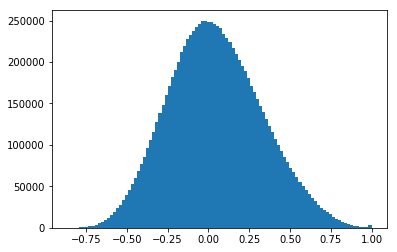

In [22]:
# Calculate the correlation matrix for the flyatlas data
unsigned_correlation = calculate_unsigned_correlation(tissue_expression)
_ = plt.hist(unsigned_correlation.flatten(), bins=100)

**Task 1(c)**

Why are we using an unsigned correlation matrix instead of a signed correlation matrix? (max 50 words)

*# ~~ GRADED CELL - your answer here --*



## Task 2 - Building an adjacency matrix

To use the correlation matrix to create a network, we will transform it into an adjacency matrix. You will create two types of adjacency matrix, a binary adjacency matrix and a weighted adjacency matrix.

**Task 2(a)**

To create the binary adjacency matrix, transform the correlation matrix such that every correlation greater than or equal to a given threshold value is considered adjacent (represented by a 1 in the matrix), and every correlation below that value is considered not adjacent (represented by a 0). Set the diagonal of the adjacency matrix to 0, so that we don't consider a node to be adjacent to itself.

In [23]:
# ~~ GRADED CELL - complete this cell ~~

def calculate_binary_adjacencies(correlation, threshold):
    '''
    Given a correlation matrix between genes of shape (N,N),
    return the corresponding binary adjacency matrix of shape (N,N),
    where correlation values are above the given threshold.
    '''
    # create a list as the binary adjacency matrix
    bin_adj_matrix = list()
    
    for row_idx, row in enumerate(correlation):
        # create a list of lists
        bin_adj_matrix.append(list())
        for col_idx, col in enumerate(row):
            # init the lists
            bin_adj_matrix[row_idx].append(0.00)
            if row_idx == col_idx:
                # set the diagonal of the adjacency matrix to 0
                bin_adj_matrix[row_idx][col_idx] = 0.00
            elif row_idx < col_idx:
                if col >= threshold:
                    # set 1 to the cell whose correlation is greater than or euqal to the threshold 
                    bin_adj_matrix[row_idx][col_idx] = 1.00
                else:
                    # set 0 to the cell whose correlation is smaller than the threshold 
                    bin_adj_matrix[row_idx][col_idx] = 0.00
            else:
                # transpose the matrix since it is symmetric
                bin_adj_matrix[row_idx][col_idx] = bin_adj_matrix[col_idx][row_idx]
    
    # convert the 2D-list to ndarray
    return np.array(bin_adj_matrix)

The below test case should return (if displayed to a precision of two decimal places)

```
array([[ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.],
       [ 0.,  0.,  1.,  0.]])
```

In [24]:
test_corr = np.array([[ 1.  ,  0.95,  0.3 ,  0.15],
       [ 0.95,  1.  ,  0.59,  0.46],
       [ 0.3 ,  0.59,  1.  ,  0.99],
       [ 0.15,  0.46,  0.99,  1.  ]])
calculate_binary_adjacencies(test_corr, 0.5)

array([[ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.],
       [ 0.,  0.,  1.,  0.]])

The below test case should return (if displayed to a precision of two decimal places)

```
array([[ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.]])
```

In [25]:
test_corr = np.array([[ 1.  ,  0.95,  0.3 ,  0.15],
       [ 0.95,  1.  ,  0.59,  0.46],
       [ 0.3 ,  0.59,  1.  ,  0.99],
       [ 0.15,  0.46,  0.99,  1.  ]])
calculate_binary_adjacencies(test_corr, 0.6)

array([[ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.]])

In [26]:
# Calculate the binary adjacency matrix for the flyatlas data
adjacency_binary = calculate_binary_adjacencies(unsigned_correlation, 0.85)

**Task 2(b)**

Calculate the connectivity of the adjacency matrix by dividing the total number of edges by the number of possible edges.

In [27]:
# ~~ GRADED CELL - complete this cell ~~

def calculate_connectivity(adjacency):
    '''
    Calculate the number of edges that exist in a given binary adjacency matrix,
    divided by the total number of possible edges between all nodes.
    '''
    # init the connectivity and the edges
    connectivity = 0
    edge_num = 0
    
    for row_idx, row in enumerate(adjacency):
        for col_idx, col in enumerate(row):
            if row_idx < col_idx:
                # only need to caluculate the upper part of the matrix
                if col == 1.00:
                    edge_num += 1
    
    # double the edges in the upper part, and exclude the diagonal values as the size
    connectivity = (edge_num * 2) / (len(adjacency) ** 2 - len(adjacency))
    
    return connectivity

In [28]:
# Should return 0.5
calculate_connectivity(np.array([[ 0.,  1.,  0.,  0.],
                                   [ 1.,  0.,  1.,  0.],
                                   [ 0.,  1.,  0.,  1.],
                                   [ 0.,  0.,  1.,  0.]]))

0.5

In [29]:
# Should return 0.33
calculate_connectivity(np.array([[ 0.,  1.,  0.,  0.],
                                   [ 1.,  0.,  0.,  0.],
                                   [ 0.,  0.,  0.,  1.],
                                   [ 0.,  0.,  1.,  0.]]))

0.3333333333333333

In [30]:
calculate_connectivity(adjacency_binary)

0.0015760455924674966

**Task 2(c)**

The weighted adjacency matrix can be created by raising the correlation matrix to some power. Write a function that raises the correlation matrix to some power, `beta`, and sets the diagonal to `0`. For the rest of the assignment we will use `beta = 4` but your function should accept any integer.

In [31]:
# ~~ GRADED CELL - complete this cell ~~

def calculate_weighted_adjacencies(correlation, beta):
    '''
    Given a correlation matrix between genes of shape (N,N),
    return the corresponding binary adjacency matrix of shape (N,N),
    where we use a power-law soft threshold with parameter beta.
    '''
    # create a list as the weighted adjacency matrix
    wgt_adj_matrix = list()
    
    for row_idx, row in enumerate(correlation):
        # create a list of lists
        wgt_adj_matrix.append(list())
        for col_idx, col in enumerate(row):
            # init the lists
            wgt_adj_matrix[row_idx].append(0.00)
            if row_idx == col_idx:
                # set the diagonal of the adjacency matrix to 0
                wgt_adj_matrix[row_idx][col_idx] = 0.00
            elif row_idx < col_idx:
                # set 0 to the cell whose correlation is smaller than the threshold 
                wgt_adj_matrix[row_idx][col_idx] = col ** beta
            else:
                # transpose the matrix since it is symmetric
                wgt_adj_matrix[row_idx][col_idx] = wgt_adj_matrix[col_idx][row_idx]
    
    # convert the 2D-list to ndarray
    return np.array(wgt_adj_matrix)

The below test case should return (if displayed to a precision of two decimal places)

```
array([[ 0.  ,  0.9 ,  0.09,  0.02],
       [ 0.9 ,  0.  ,  0.35,  0.21],
       [ 0.09,  0.35,  0.  ,  0.98],
       [ 0.02,  0.21,  0.98,  0.  ]])
```

In [32]:
test_corr = np.array([[ 1.  ,  0.95,  0.3 ,  0.15],
       [ 0.95,  1.  ,  0.59,  0.46],
       [ 0.3 ,  0.59,  1.  ,  0.99],
       [ 0.15,  0.46,  0.99,  1.  ]])
calculate_weighted_adjacencies(test_corr, 2)

array([[ 0.  ,  0.9 ,  0.09,  0.02],
       [ 0.9 ,  0.  ,  0.35,  0.21],
       [ 0.09,  0.35,  0.  ,  0.98],
       [ 0.02,  0.21,  0.98,  0.  ]])

The below test case should return (if displayed to a precision of two decimal places)

```
array([[ 0.  ,  0.86,  0.03,  0.  ],
       [ 0.86,  0.  ,  0.21,  0.1 ],
       [ 0.03,  0.21,  0.  ,  0.97],
       [ 0.  ,  0.1 ,  0.97,  0.  ]])
```

In [33]:
test_corr = np.array([[ 1.  ,  0.95,  0.3 ,  0.15],
       [ 0.95,  1.  ,  0.59,  0.46],
       [ 0.3 ,  0.59,  1.  ,  0.99],
       [ 0.15,  0.46,  0.99,  1.  ]])
calculate_weighted_adjacencies(test_corr, 3)

array([[ 0.  ,  0.86,  0.03,  0.  ],
       [ 0.86,  0.  ,  0.21,  0.1 ],
       [ 0.03,  0.21,  0.  ,  0.97],
       [ 0.  ,  0.1 ,  0.97,  0.  ]])

In [34]:
# Calculate the weighted adjacency matrix for the flyatlas data
adjacency_weighted = calculate_weighted_adjacencies(unsigned_correlation, 4)

**Task 2(d)**

How do you expect the network connectivity would change if the threshold for the binary adjacency matrix is increased or decreased? (max 50 words)

*# ~~ GRADED CELL - your answer here --*


## Task 3 - Defining modules with hierarchical clustering

We will implement a distance or dissimilarity function between genes that makes use of the gene network as specified by the adjacency matrix, and these distances to carry out hierarchical clustering. We'll use scipy's hierarchical clustering functions `linkage()` and `fcluster()`, as they provide us with an easy way to draw the dendrogram.

The distance or dissimilarity function we'll implement is based on that given in lectures:

If $i=j$, 

$$d_{ij} = 0$$

otherwise

$$d_{ij} = 1 - \frac{l_{ij} + a_{ij}}{min(k_i,k_j) + 1 - a_{ij}}$$

where

$$l_{ij} = \Sigma_u a_{iu} a_{uj}$$

$$k_i = \Sigma_u a_{iu}$$

and $a_{ij}$ refers to the $i$,$j$th element of the adjacency matrix.

Note we have set $d_{ij}$ to $0$ if $i=j$ as this is the distance from a node to itself.

In the functions below we'll refer to $k_i$ as the vertex connectivity of node $i$ (i.e. gene $i$), and $l_{ij}$ as the neighbour connectivity between $i$ and $j$. 

**Task 3(a)**

In the distance metric above, $l_{ij}$ sums over every node in the graph, but only a subset of nodes contribute. Based on the equations when applied to the binary adjacency matrix, explain which subset of nodes contribute to $d_{ij}$ for a given $i$ and $j$. (max 50 words)


*# ~~ GRADED CELL - your answer here --*


**Task 3(b)**

Complete the `vertex_connectivity()` and `neighbour_connectivity()` functions below. The `distance_matrix()` function has been provided, and should work correctly once the other two functions are complete.

In [35]:
# ~~ GRADED CELL - complete this cell ~~

def vertex_connectivity(adjacency):
    '''
    Given an adjacency matrix of shape (N,N), calculate the
    vertex connectivity k_i of every node i and return these as an array of
    shape (N,1).
    '''
    # create vertex connectivity list
    vertex_conn = list()
    
    # loop the adjacency matrix by column
    for col in adjacency.T:
        # append sum values of a column to the list
        vertex_conn.append(sum(col))
    
    # convert list to ndarray
    return np.array(vertex_conn)

In [36]:
# ~~ GRADED CELL - complete this cell ~~

def neighbour_connectivity(adjacency):
    '''
    Given the adjacency matrix of shape (N,N), calculate the sum
    of path weights from every i to every j via a single neighbouring node,
    i.e. Sum a_iu a_uj over all nodes u.
    Return these path weights from i to j in a matrix of shape (N,N)
    '''
    # create neighbour connectivity list
    ngh_conn = list()
    
    for row_idx, row in enumerate(adjacency):
        # create a list of 
        ngh_conn.append(list())
        for col_idx, col in enumerate(row):
            ngh_conn[row_idx].append(0.00)
            if row_idx <= col_idx:
                sum_val = 0
                for u in range(len(adjacency)):
                    sum_val += adjacency[row_idx][u] * adjacency[u][col_idx]
                ngh_conn[row_idx][col_idx] = sum_val
            else:
                # transpose the matrix since it is symmetric
                ngh_conn[row_idx][col_idx] = ngh_conn[col_idx][row_idx]
    
    # convert list to ndarray
    return np.array(ngh_conn)

In [41]:
def distance_matrix(adjacency):
    '''
    Given the adjacency matrix of shape (N,N), calculate the distance 
    between every i and j based on the dissamilarity formula provided in lectures,
    and return these distances in a matrix of shape (N,N).
    '''
    l_ij = neighbour_connectivity(adjacency)
    k_i = vertex_connectivity(adjacency)[:,np.newaxis]
    print(k_i)
    k_j = vertex_connectivity(adjacency)[np.newaxis,:]
    print(k_j)
    print(np.minimum(k_i,k_j))
    d_ij = 1 - ((l_ij + adjacency) / (np.minimum(k_i,k_j) + 1 - adjacency))
    np.fill_diagonal(d_ij, 0)
    return d_ij

The below test case should return (if displayed to a precision of two decimal places)

```
array([ 0.89,  1.17,  1.21,  1.07])
```

In [42]:
vertex_connectivity(np.array([[ 0.  ,  0.86,  0.03,  0.  ],
                           [ 0.86,  0.  ,  0.21,  0.1 ],
                           [ 0.03,  0.21,  0.  ,  0.97],
                           [ 0.  ,  0.1 ,  0.97,  0.  ]]))

array([ 0.89,  1.17,  1.21,  1.07])

The below test case should return (if displayed to a precision of two decimal places)

```
array([[ 0.74,  0.01,  0.18,  0.12],
       [ 0.01,  0.79,  0.12,  0.2 ],
       [ 0.18,  0.12,  0.99,  0.02],
       [ 0.12,  0.2 ,  0.02,  0.95]])
```

In [43]:
neighbour_connectivity(np.array([[ 0.  ,  0.86,  0.03,  0.  ],
                           [ 0.86,  0.  ,  0.21,  0.1 ],
                           [ 0.03,  0.21,  0.  ,  0.97],
                           [ 0.  ,  0.1 ,  0.97,  0.  ]]))

array([[ 0.74,  0.01,  0.18,  0.12],
       [ 0.01,  0.79,  0.12,  0.2 ],
       [ 0.18,  0.12,  0.99,  0.02],
       [ 0.12,  0.2 ,  0.02,  0.95]])

The below test case should return (if displayed to a precision of two decimal places)

```
array([[ 0.  ,  0.16,  0.89,  0.94],
       [ 0.16,  0.  ,  0.83,  0.85],
       [ 0.89,  0.83,  0.  ,  0.1 ],
       [ 0.94,  0.85,  0.1 ,  0.  ]])
```

In [44]:
distance_matrix(np.array([[ 0.  ,  0.86,  0.03,  0.  ],
                       [ 0.86,  0.  ,  0.21,  0.1 ],
                       [ 0.03,  0.21,  0.  ,  0.97],
                       [ 0.  ,  0.1 ,  0.97,  0.  ]]))

[[ 0.89]
 [ 1.17]
 [ 1.21]
 [ 1.07]]
[[ 0.89  1.17  1.21  1.07]]
[[ 0.89  0.89  0.89  0.89]
 [ 0.89  1.17  1.17  1.07]
 [ 0.89  1.17  1.21  1.07]
 [ 0.89  1.07  1.07  1.07]]


array([[ 0.  ,  0.16,  0.89,  0.94],
       [ 0.16,  0.  ,  0.83,  0.85],
       [ 0.89,  0.83,  0.  ,  0.1 ],
       [ 0.94,  0.85,  0.1 ,  0.  ]])

In [ ]:
# Calculate the distance matrix for flyatlas data
distances = distance_matrix(adjacency_weighted)

We can now carry out hierarchical clustering. Here, scipy's `linkage()` function performs agglomerative clustering based on the provided distances. 

The most important function below is `linkage()`. Other functions you see are `squareform()`, a utility function to transform the distance matrix into the format scipy requires, and `transpose()`, which is here used to compensate for small floating-point errors and ensure the distance matrix is exactly symmetric.

In [ ]:
Z = linkage(squareform((distances+distances.transpose())/2), 'ward')

Scipy provides a function to draw the dendrogram:

In [ ]:
plt.figure(figsize=(25, 10))
_ = dendrogram(Z, no_labels=True)
plt.axhline(y = 4.5, color = 'r', linestyle = '--')

And we can extract the desired number of flat clusters with `fcluster()`:

In [ ]:
labels = fcluster(Z, 6, criterion='maxclust')

We now have a numpy array assigning each gene to one of 6 clusters, labelled 1 to 6:

In [ ]:
labels[:10]

**Task 3(c)**

Write a function to convert this flat list of labels into a set of modules in the form of lists of gene names.

In [ ]:
# ~~ GRADED CELL - complete this cell ~~

def module_lists(genes, labels):
    '''
    Given an array or series of gene names and an array or series of cluster labels,
    return a list of lists where each list represents the genes in a cluster.
    '''


In [ ]:
# Should return [['GeneA', 'GeneC'], ['GeneB'], ['GeneD']]
module_lists(['GeneA', 'GeneB', 'GeneC', 'GeneD'], [1,2,1,3])

In [ ]:
# Get our flyatlas module lists
modules_hierarchical = module_lists(tissue_expression.index, labels)

# The sizes of our modules
[len(module) for module in modules_hierarchical]

In [ ]:
# The modules themselves
modules_hierarchical

## Task 4 - Clustering with k-medoids 

In this task, we'll use a different clustering method and see what modules we get.

We don't have a Euclidean distance space, but we have a pairwise matrix of distances, which allows us to implement k-medoids. Recall that in k-medoids, one of our data points acts as the centroid of each cluster - in this case there will be a centroid gene for each cluster. The algorithm we will implement for k-medoids is:

1. Initialise the centroids randomly.
2. Assign each gene to the closest centroid (in this case, using our network-based distances).
3. Choose the most-central gene in each cluster to be the new centroid. This is the gene which minimises the sum of squared distances within the cluster.
4. Repeat from step (2) until the algorithm converges and the centroids no longer change.

The functions `initialise_centroids()` and `calculate_new_centroids()` are provided for you. You need to implement `assign_points()` and complete the function `kmedoids()` itself.

In [ ]:
def initialise_centroids(N, k):
    """
    Select k centroid indices randomly given that there are N data points.
    We are only selecting the indices, so we don't need the actual data.
    """
    centroid_indices = np.random.choice(list(range(N)), size=k, replace=False)
    return centroid_indices 

In [ ]:
def calculate_centroid_index(within_cluster_distances):
    """
    Take in distance array of size (C,C) where C is the size of the cluster.
    Return a centroid index (of type int) which is the most-central data point.
    """
    # We'll minimise the sum of square distances
    # Calculate this quantity for every point, and pick the best as the centroid
    sse = np.sum((within_cluster_distances**2),axis=1)
    return np.argmin(sse)

def calculate_new_centroids(distances, assignments, k):
    """
    Take distances of shape (N,N) and cluster assignments of shape (N) and
    return centroid indices array of shape (k).
    """
    assert np.max(assignments) < k
    centroid_list = []
    for c in range(k):
        in_cluster = assignments==c
        cluster_distances = distances[in_cluster,:][:,in_cluster]
        centroid_index_in_cluster = calculate_centroid_index(cluster_distances)
        centroid_index = np.array(list(range(len(distances))))[in_cluster][centroid_index_in_cluster]
        centroid_list.append(centroid_index)
    return np.array(centroid_list)

In [ ]:
# ~~ GRADED CELL - complete this cell ~~

def assign_points(centroid_indices, distances):
    """
    Assign each point to its closest centroid.
    Take in an array of centroid indices of length k, and an array representing
    the distance matrix, of shape (N,N).
    Return a 1D array of length N representing cluster assignments.
    Each value in the returned array should be a number from 0 to k-1,
    indicating which cluster (centroid) this data point has been assigned to.
    """


In [ ]:
# ~~ GRADED CELL - complete this cell ~~

def kmedoids(distances, k):
    """
    Implement k-medoids clustering on a given set of points, by taking in
    a pre-computed distance matrix of size (N,N), and a number of clusters k.
    Returns a tuple of (centroid_indices, cluster_assignments)
    where 
    centroid_indices is a list of indices specifying which data points are now
     centroids, and
    cluster_assignments is a 1D array of length N, where the values of the
     array are numbers from 0 to k-1 and represent cluster assignments.
    """


In [ ]:
# Should return array([0, 0, 1, 1])

test_dist = np.array([[ 0.  ,  0.16,  0.89,  0.94],
       [ 0.16,  0.  ,  0.83,  0.85],
       [ 0.89,  0.83,  0.  ,  0.1 ],
       [ 0.94,  0.85,  0.1 ,  0.  ]])
assign_points([0,2], test_dist)

In [ ]:
# Should return array([0, 1, 1, 1])

test_dist = np.array([[ 0.  ,  0.16,  0.89,  0.94],
       [ 0.16,  0.  ,  0.83,  0.85],
       [ 0.89,  0.83,  0.  ,  0.1 ],
       [ 0.94,  0.85,  0.1 ,  0.  ]])
assign_points([0,1], test_dist)

In [ ]:
# k-medoids is stochastic, so you're not guaranteed to get the correct result every 
# time for this test. However the most likely outcome is
# (array([2, 0]), array([1, 1, 0, 0]))
# or equivalently
# (array([0, 2]), array([0, 0, 1, 1]))

test_dist = np.array([[ 0.  ,  0.16,  0.89,  0.94],
       [ 0.16,  0.  ,  0.83,  0.85],
       [ 0.89,  0.83,  0.  ,  0.1 ],
       [ 0.94,  0.85,  0.1 ,  0.  ]])
kmedoids(test_dist, 2)

Now we can cluster our data:

In [ ]:
# Cluster our flyatlas data
centroids, kmedoids_labels = kmedoids(distances, 6)

In [ ]:
# genes that are the centroids
tissue_expression.index[centroids]

In [ ]:
# Use the module_lists function you defined earlier
modules_kmedoids = module_lists(tissue_expression.index, kmedoids_labels)

# Module sizes
[len(m) for m in modules_kmedoids]

In [ ]:
# The modules themselves
modules_kmedoids

## Task 5 - Dimension Reduction

In this task we will be performing Priciple Components Analysis to determine which gene in the first principle component has the highest contribution to the varience.

**Task 5(a)**

Perform a Principle Componanets Analysis on the log_expression matrix with the correct number of components and print the explained variance by component list (like we saw in the week 9 tutorial)

In [ ]:
# ~~ GRADED CELL - complete this cell ~~

**Task 5(b)**

Print the gene that contributes most to the first eigen vector (the first principle component) of the PCA. The word limit on the second cell is 50 words.

In [1]:
# ~~ GRADED CELL - complete this cell ~~

## Task 6 - Centrality

In this task we will be computing differing measures of centrality in the gene found above in Task 5. 

**Task 6 (a)**

Degree Centrality

Using the adjacency_binary matrix (with a threshold value of 0.85) claculate the degree centrality of the gene found in Task 5.

In [ ]:
# ~~ GRADED CELL - your code here --

**Task 6 (b)**

Betweeness Centrality

Using the adjacency_binary matrix generated above(with a threshold value of 0.85), turn the matrix into a graph object (using networkx) and then claculate the betweeness centrality of the gene found in Task 5 using the [networkx function for betweeness centrality](https://networkx.github.io/documentation/networkx-2.2/reference/algorithms/generate/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality).

In [ ]:
# ~~ GRADED CELL - your code here --

**Task 6 (c)**

Closeness Centrality

Using the [dijkstra_path](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.dijkstra_path.html) function from networkx claculate the closeness centrality of the gene found in Task 5 using the following formula:


$$C(u) = \frac{n - 1}{\sum_{v=1}^{n-1} d(v, u)}$$

where d(v, u) is the shortest-path distance between v and u, and n is the number of nodes that can reach u.

In [2]:
# ~~ GRADED CELL - your code here --

**Task 6 (d)**

What does each measurement say about the gene's centrality? Is it relatively central? 


*# ~~ GRADED CELL - your answer here --*
